In [68]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
data = pd.read_csv("./유방암.CSV",engine="python")
data.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

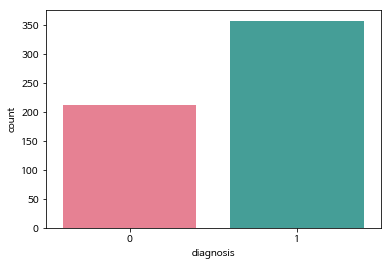

In [69]:
# 결측치 없다.
data.isnull().sum(axis=0)
#데이터 타입 확인
data.info()
# Checking if classes are unbalanced or balanced
data['diagnosis'].value_counts()
# '1' 은 Malignant으로 악성이다 -> 212/(212 + 357) = 0.37 
# '0' 은 Benign으로 양성이다 -> 357/(212+357) = 0.627
sns.countplot(data.diagnosis)
sns.countplot(data['diagnosis'],  palette = "husl")

# 데이터 스케일
- **1. 모든 분포가 왼쪽으로 치우쳐 있기 때문에 로그 변환을 적용해 분포를 보다 정상으로 만들고 왼쪽 꼬리를 중앙으로 sacle한다**

- **2. 전체 데이터를 (0,1)사이의 MinMaxScaler과 평균 0 표준 편차 1 만들어 값을 변화시킨다.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EAAD52A358>,
      dtype=object)

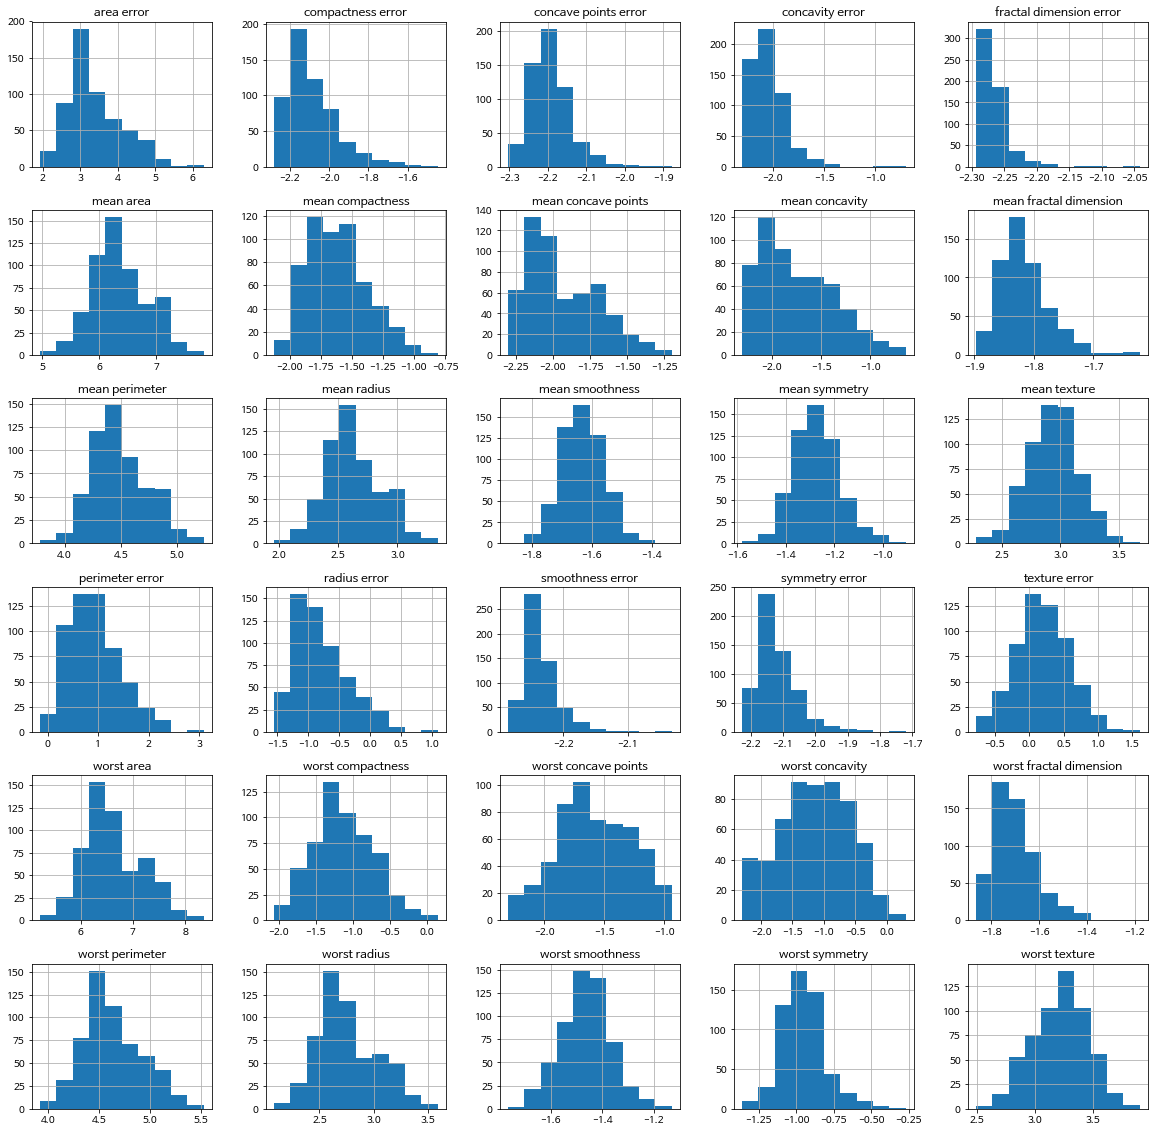

In [70]:
data_x = data.drop("diagnosis",axis=1)
data_y = data["diagnosis"]

X_log = data_x.apply(lambda x: np.log(x + 0.1))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)
X_log.hist(figsize = (20,20))

# 데이터 분할 (train, test 데이터 7:3)
- Data set을 train과 test로 나누고 초기화한다

In [71]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(data.shape[0]) < 0.7
data_train = data[msk]
data_test = data[~msk]

# train/test 데이터의 목표변수/설명변수 지정
data_train_y = data_train["diagnosis"]
data_train_x = data_train.drop("diagnosis", axis=1, inplace=False)
data_test_y = data_test["diagnosis"]
data_test_x = data_test.drop("diagnosis", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(data_train_x.shape))
print("train data Y size: {}".format(data_train_y.shape))
print("test data X size: {}".format(data_test_x.shape))
print("test data Y size: {}".format(data_test_y.shape))

# train data: 385, test data: 184

train data X size: (385, 30)
train data Y size: (385,)
test data X size: (184, 30)
test data Y size: (184,)


# SVC 정확도 비교
- Accuracy on training set:1.0
- Accuracy on training set:0.65

In [72]:
rf_uncustomized = SVC(random_state=1234)
rf_uncustomized.fit(data_train_x, data_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(rf_uncustomized.score(data_train_x,
                                                                      data_train_y)))
print("Accuracy on training set:{:3f}".format(rf_uncustomized.score(data_test_x,
                                                                      data_test_y)))

Accuracy on training set:1.000
Accuracy on training set:0.652174


# tree model 옵션 확인

In [73]:
rf_uncustomized.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)>

# GridSearchCV 사용
- **CRiterion: 분리 기준 변경(gini, entropy)**
- **depth는 1~50까지 잡는다. (tree - 최대 깊이)**
- **num_leafs는 Tree의 leaf**
- **GridSearchCV.fit 저장**

In [74]:
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(data_train_x, data_train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1234,
  shrinking=True, tol=0.001, verbose=False)

# SVM Model 생성
- **accuracy와 recall을 점수 측정 지표로 사용**
- **두 model 둘다 최적 model과 동일한 모델을 사용한다**

In [75]:
svc=SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['accuracy', 'recall']
for sc in scores:
    grid=GridSearchCV(svc,param_grid,cv=10,scoring=sc,n_jobs=-1)
    print("# Tuning hyper-parameters for %s" % sc)
    grid.fit(data_train_x,data_train_y)
    print(grid.best_params_)
    print("best_score : ", np.round(grid.best_score_,3))

# Tuning hyper-parameters for accuracy
{'C': 10, 'kernel': 'linear'}
best_score :  0.956
# Tuning hyper-parameters for recall
{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
best_score :  0.975


# GridSearch 출력
- **GridSearch를 했을 때 가장좋은 test accuracy중 가장 좋은 score를 출력**
- **그 때 조합들의 parameter를 출력했다.**

In [76]:
print(grid.best_score_)
print(grid.best_params_)

0.9745765104460755
{'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}


In [77]:
my_model = grid.best_estimator_
my_model.fit(data_train_x,data_train_y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Roc curve 함수
- ROC(Receiver Operator Characteristic) 커브는 클래스 판별 기준값의 변화에 따른 위양성률(fall-out)과 재현율(recall)의 변화를 시각화한 것이다.

- 모든 이진 분류 모형은 판별 평면으로부터의 거리에 해당하는 판별 함수(discriminant function)를 가지며 판별 함수 값이 음수이면 0인 클래스, 양수이면 1인 클래스에 해당한다고 판별한다. 즉 0 이 클래스 판별 기준값이 된다. ROC 커브는 이 클래스 판별 기준값이 달라진다면 판별 결과가 어떻게 달라지는지는 표현한 것이다.

- Scikit-Learn 의 Classification 클래스는 다음처럼 판별 함수 값을 계산하는 decision_function 메서드를 제공한다. 다음 표는 분류 문제를 풀고 decision_function 메서드를 이용하여 모든 표본 데이터에 대해 판별 함수 값을 계산한 다음 계산된 판별 함수 값이 가장 큰 데이터부터 가장 작은 데이터 순서로 정렬한 것이다.

In [78]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# svc 와 svc1 비교 
- **svc는 임의로 parameter 지정**
- **svc1이 GridSearch를 통해 구한 최적의 parameter**

SVC:
 confusion matrix
 [[ 60   4]
 [ 13 107]] 


Confusion matrix plot of SVC


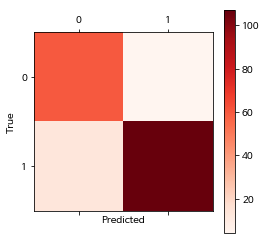


 Classification report 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        64
           1       0.96      0.89      0.93       120

   micro avg       0.91      0.91      0.91       184
   macro avg       0.89      0.91      0.90       184
weighted avg       0.91      0.91      0.91       184


 Classification report 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        64
           1       0.96      0.89      0.93       120

   micro avg       0.91      0.91      0.91       184
   macro avg       0.89      0.91      0.90       184
weighted avg       0.91      0.91      0.91       184



In [79]:
# SVC
# fitting the SVC model on the training data and predicting for test data
svc=SVC(C=100,gamma=0.001,kernel='rbf',probability=True)
svc1=SVC(C=10,gamma=0.00001,kernel='rbf',probability=True)
svc.fit(data_train_x, data_train_y)
svc1.fit(data_train_x, data_train_y)
y_pred_svc =svc.predict(data_test_x)
y_pred_svc1 =svc.predict(data_test_x)
# computing and plotting confusion matrix
c_m = confusion_matrix(data_test_y, y_pred_svc)
c_m1 = confusion_matrix(data_test_y, y_pred_svc1)
print('SVC:\n confusion matrix\n', c_m,'\n\n')
ax=plt.matshow(c_m,cmap=plt.cm.Reds)
print('Confusion matrix plot of SVC')
plt.colorbar(ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# classification report
print('\n Classification report \n',classification_report(data_test_y, y_pred_svc))
print('\n Classification report \n',classification_report(data_test_y, y_pred_svc1))

# ROC Curve for Cancer classifier
- **Threshold 값 0.5는 예측 된 확률을 클래스 예측으로 변환하기 위해 사용한다.**
- **sensitivity/recall을 조정하기위해 Threshold값 조정 가능**
- **0.2 이후SVC1은 거의 classifier가 1.0에 수렴하는 것을 보인다.**

model: SVC
thresholds: [2.   1.   0.92 0.92 0.9  0.9  0.87 0.86 0.75 0.64 0.44 0.41 0.41 0.41
 0.35 0.33 0.28 0.27 0.23 0.17 0.17 0.17 0.17 0.16 0.08 0.08 0.06 0.06
 0.02 0.   0.  ]
tpr:        [0.   0.01 0.76 0.76 0.8  0.8  0.82 0.82 0.88 0.88 0.91 0.91 0.92 0.92
 0.93 0.93 0.94 0.94 0.96 0.96 0.97 0.97 0.97 0.98 0.98 0.98 0.98 0.99
 0.99 1.   1.  ]
fpr:        [0.   0.   0.   0.02 0.02 0.03 0.03 0.05 0.05 0.06 0.06 0.08 0.08 0.09
 0.09 0.11 0.11 0.12 0.12 0.14 0.14 0.28 0.44 0.44 0.89 0.89 0.92 0.92
 0.98 0.98 1.  ]
model: SVC1
thresholds: [1.99 0.99 0.95 0.95 0.88 0.87 0.78 0.77 0.77 0.74 0.73 0.72 0.7  0.69
 0.59 0.5  0.39 0.08 0.07 0.03 0.03 0.  ]
tpr:        [0.   0.01 0.38 0.38 0.88 0.88 0.93 0.93 0.94 0.94 0.95 0.95 0.96 0.96
 0.98 0.98 0.99 0.99 1.   1.   1.   1.  ]
fpr:        [0.   0.   0.   0.02 0.02 0.03 0.03 0.05 0.05 0.06 0.06 0.08 0.08 0.09
 0.09 0.11 0.11 0.22 0.22 0.38 0.41 1.  ]


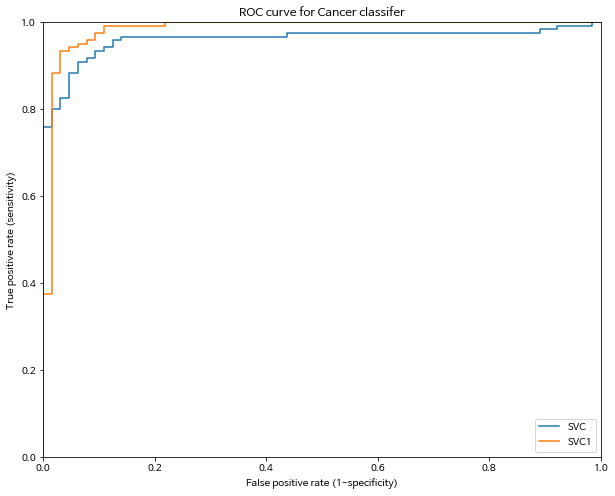

In [80]:
# false positive rate,fpr= FP/(TN+FP) OR fpr=1-specificty, tpr=sensitivity 
y_pred_svc_p =svc.predict_proba(data_test_x)[:,1]
y_pred_svc_p1 =svc1.predict_proba(data_test_x)[:,1]
models=[y_pred_svc_p,y_pred_svc_p1]
label=['SVC','SVC1']

# plotting ROC curves
plt.figure(figsize=(10, 8))
m=np.arange(2)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(data_test_y,models[m])
    print('model:',label[m])
    print('thresholds:',np.round(thresholds,2))
    print('tpr:       ',np.round(tpr,2))
    print('fpr:       ',np.round(fpr,2))
    plt.plot(fpr,tpr,label=label[m])
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC curve for Cancer classifer')
plt.xlabel('False positive rate (1-specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.legend(loc=4,)